# ECP Pre-processing
**Purpose: Convert raw ECP data to YOLO and COCO label formats**</br>
**Final Project**</br>
**Group 1**</br>
**DS6050 Deep Learning**</br>
**Fall 2023**</br>

In [4]:
%pip install pylabel pyyaml -q

In [44]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import shutil
from PIL import Image
from PIL import ImageDraw
import cv2
import numpy as np

## Download Data
Download the raw ECP data from the following link: https://eurocity-dataset.tudelft.nl/eval/user/login?_next=/eval/downloads/detection. Make sure the data is all in the same folder.

## Unzip Data

Execute `unzip` on each ECP zipfile. The data should unpack as follows:

```
ECP/
  day/
    img/
      val/
      train/
      test/
    labels/
      train/
      val/
  night/
    img/
      val/
      train/
      test/
    labels/
      train/
      val/
```

In [36]:
# Function to recursively search for JSON files
def find_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

## Get Label Categories

In [38]:
# Define the main folder path
folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP'

# Get a list of JSON files in subfolders
json_files = find_json_files(folder_path)

identities = set()
# Iterate over the JSON files and load their contents
for json_file in json_files:
    with open(json_file, 'r') as file:
        data = json.load(file)
        # Process the loaded JSON data here
        for item in data['children']:
            identities.add(item['identity'])

identity_mapping = {value: index for index, value in enumerate(identities)}
identity_mapping

{'pedestrian': 0,
 'bicycle': 1,
 'bicycle-group': 2,
 'motorbike-group': 3,
 'scooter-group': 4,
 'rider+vehicle-group-far-away': 5,
 'motorbike': 6,
 'wheelchair-group': 7,
 'buggy-group': 8,
 None: 9,
 'person-group-far-away': 10,
 'rider': 11,
 'tricycle-group': 12}

## Create YOLO Labels

In [39]:
# Function to normalize coordinates with the center as (x0, y0)
def normalize_coordinates(x0, y0, x1, y1, image_width, image_height):
    normalized_x0 = (x0 + (x1 - x0) / 2) / image_width
    normalized_y0 = (y0 + (y1 - y0) / 2) / image_height
    normalized_width = (x1 - x0) / image_width
    normalized_height = (y1 - y0) / image_height
    return normalized_x0, normalized_y0, normalized_width, normalized_height

base_dir = "/scratch/ybt7qf/ds6050-group1-project/"  # modify this as needed (keep / at end)
dirs = [
    ['ECP/day/labels/train/', 'datasets/eurocitypersonsdataset/labels/train/'],
    ['ECP/night/labels/train/', 'datasets/eurocitypersonsdataset/labels/train/'],
    ['ECP/day/labels/val/', 'datasets/eurocitypersonsdataset/labels/val/'],
    ['ECP/night/labels/val/', 'datasets/eurocitypersonsdataset/labels/val/'],
]

for d in dirs:
    main_folder_path, save_dir = base_dir + d[0], base_dir + d[1]

    json_files = find_json_files(main_folder_path)

    os.makedirs(save_dir, exist_ok=True)

    # Iterate over subfolders and process JSON files
    for json_file in json_files:
        # Get the base name (with extension)
        base_name = os.path.basename(json_file)

        # Get the file name without extension
        file_name_without_extension = os.path.splitext(base_name)[0]

        with open(json_file, 'r') as file:
            data = json.load(file)

        children = data.get('children', [])
        with open(save_dir + f"{file_name_without_extension}.txt", 'w') as txt_file:
            for child in children:
                identity = child.get('identity', None)
                if identity:
                    identity_index = identity_mapping[identity]
                    x0, y0, x1, y1 = child['x0'], child['y0'], child['x1'], child['y1']
                    normalized_x0, normalized_y0, normalized_width, normalized_height = normalize_coordinates(
                        x0, y0, x1, y1, data['imagewidth'], data['imageheight']
                    )

                    # Save data in the text file
                    txt_file.write(f"{identity_index} {normalized_x0} {normalized_y0} {normalized_width} {normalized_height}\n")
                else:
                    print(f"no labels for {json_file}")
print("Processing completed.")

no labels for /scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json
Processing completed.


## Copy Images to Dataset Directory

In [102]:
base_dir = "/scratch/ybt7qf/ds6050-group1-project/" # modify this as needed (keep / at end)
dirs = [
    ['ECP/day/img/train/', 'datasets/eurocitypersonsdataset/images/train/'],
    ['ECP/night/img/train/', 'datasets/eurocitypersonsdataset/images/train/'],
    ['ECP/day/img/val/', 'datasets/eurocitypersonsdataset/images/val/'],
    ['ECP/night/img/val/', 'datasets/eurocitypersonsdataset/images/val/'],
]

for d in dirs:
    source_folder, destination_folder = base_dir+d[0], base_dir+d[1]

    os.makedirs(destination_folder, exist_ok=True)

    # Loop over all subfolders and move .png files
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith('.png'):
                source_file = os.path.join(root, file)
                destination_file = os.path.join(destination_folder, file)

                # Create the destination folder if it doesn't exist
                os.makedirs(os.path.dirname(destination_file), exist_ok=True)

                # Copy the .png file to the destination folder
                shutil.copy(source_file, destination_file)

print("PNG files copied to the destination folder.")

PNG files copied to the destination folder.


## Validate YOLO Labels

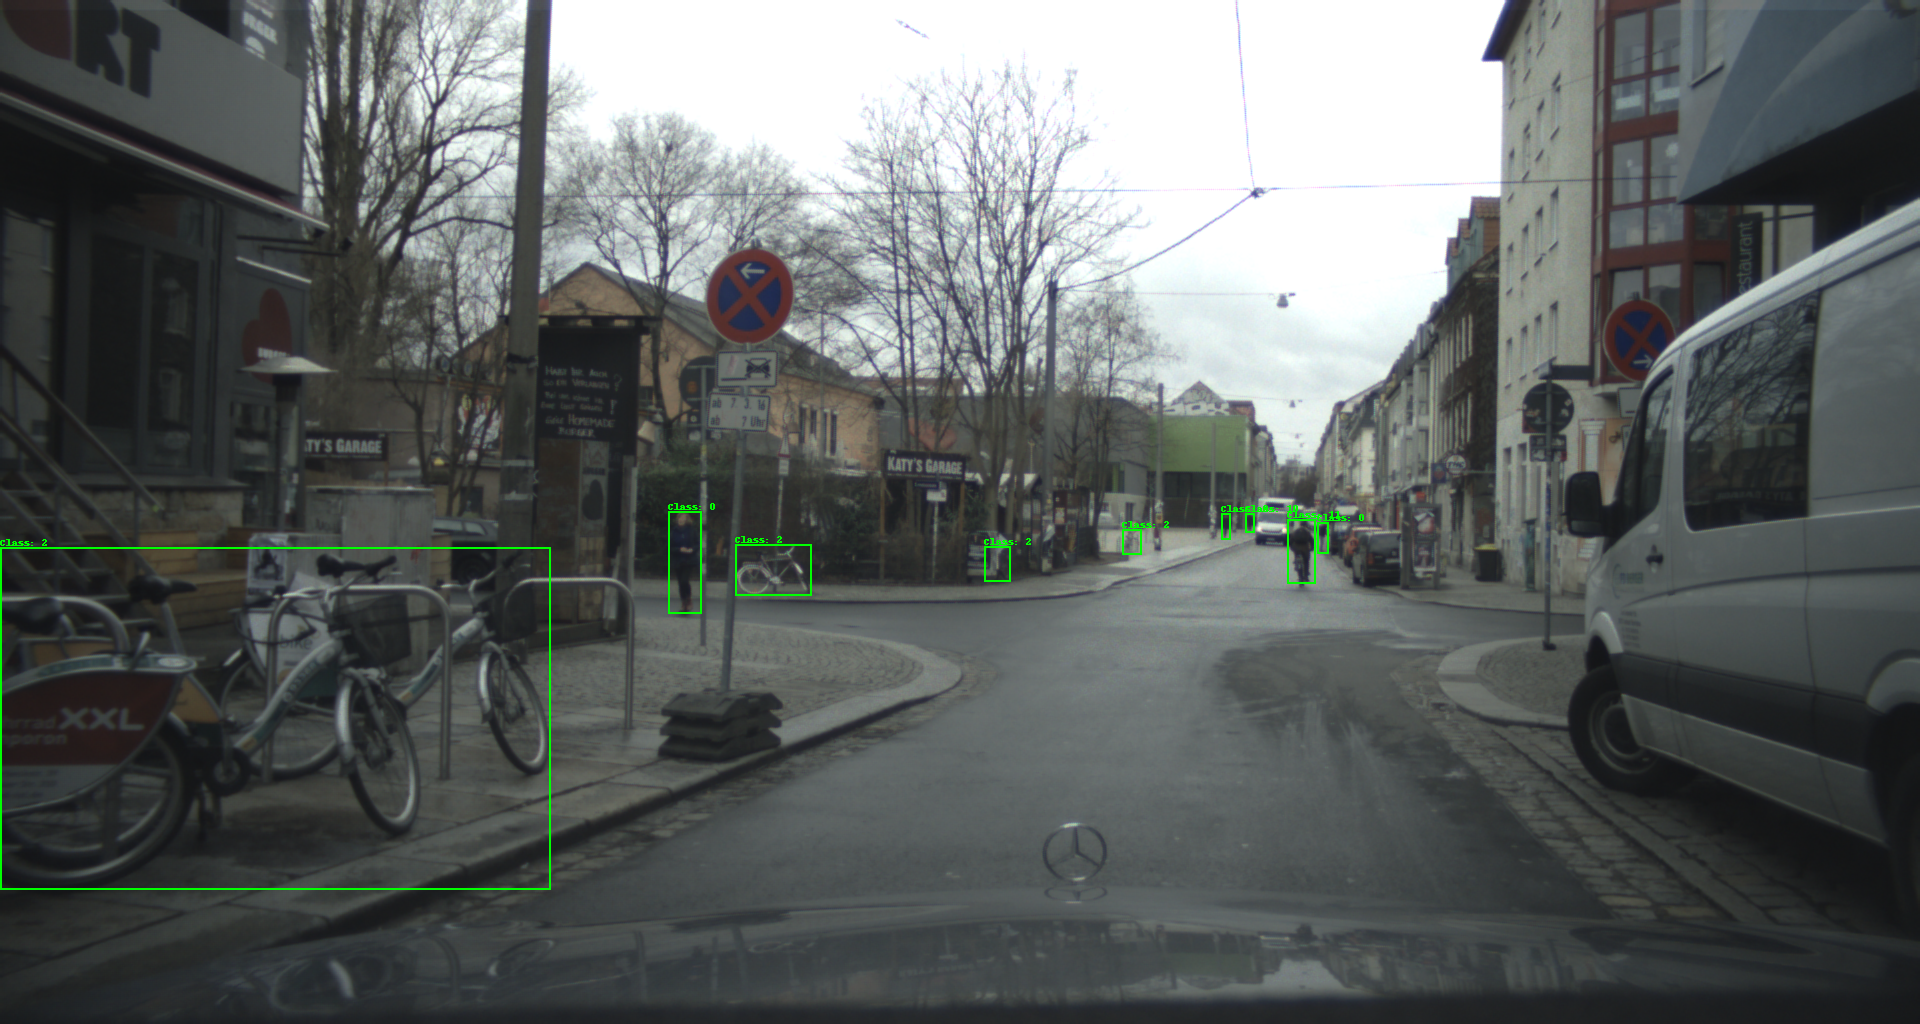

In [42]:
# Path to the YOLOv5 labels file
labels_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/dresden_00653.txt'

# Path to the image corresponding to the labels
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/dresden_00653.png'

# Load the image
image = Image.open(image_path)

# Read the YOLOv5 labels file
with open(labels_path, 'r') as file:
    labels = file.read().strip().split('\n')

draw = ImageDraw.Draw(image)

for label in labels:
    parts = label.split()
    class_id = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO format to image coordinates
    x, y, w, h = int((x_center - width / 2) * image.width), int((y_center - height / 2) * image.height), int(width * image.width), int(height * image.height)
    
    # Define a color for the bounding box (RGB format)
    color = (0, 255, 0)  # Green
    
    # Draw the bounding box on the image
    draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
    
    # Display the class label on the image
    label_text = f'Class: {class_id}'
    draw.text((x, y - 10), label_text, fill=color)

# Display the image with bounding boxes
image

## Resize Images

In [3]:
source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val/'

destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/'
# destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/'

os.makedirs(destination_folder, exist_ok=True)

desired_width = 640

def resize_image(image_path):
    with Image.open(image_path) as img:
        w, h = img.size
        new_height = int((desired_width / w) * h)
        img_resized = img.resize((desired_width, new_height), Image.ANTIALIAS)
        destination_path = os.path.join(destination_folder, os.path.basename(image_path))
        img_resized.save(destination_path, quality=90)  # Adjust quality as needed

# Get a list of image files
image_files = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]

# Using a thread pool for concurrent resizing
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    list(tqdm(executor.map(resize_image, image_files), total=len(image_files), desc="Resizing images"))

print("Images resized and saved to the destination folder.")

Resizing images: 100%|██████████| 28114/28114 [21:20<00:00, 21.96it/s]

Images resized and saved to the destination folder.


## Validate Labels on Resized Images

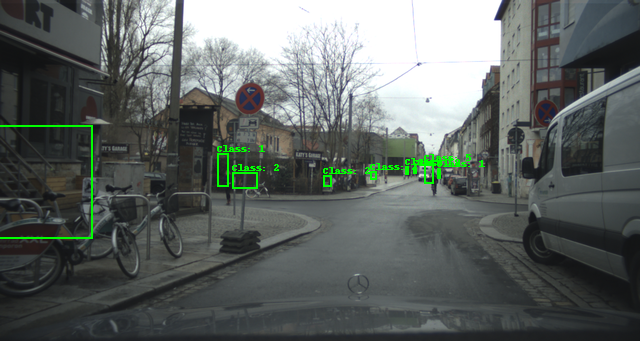

In [45]:
# Path to the YOLOv5 labels file
labels_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/dresden_00653.txt'

# Path to the image corresponding to the labels
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/dresden_00653.png'

# Load the image
image = Image.open(image_path)

# Read the YOLOv5 labels file
with open(labels_path, 'r') as file:
    labels = file.read().strip().split('\n')

draw = ImageDraw.Draw(image)

for label in labels:
    parts = label.split()
    class_id = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO format to image coordinates
    x, y, w, h = int((x_center - width / 2) * image.width), int((y_center - height / 2) * image.height), int(width * image.width), int(height * image.height)
    
    # Define a color for the bounding box (RGB format)
    color = (0, 255, 0)  # Green
    
    # Draw the bounding box on the image
    draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
    
    # Display the class label on the image
    label_text = f'Class: {class_id}'
    draw.text((x, y - 10), label_text, fill=color)

# Display the image with bounding boxes
image

## Create YOLO Yaml

In [11]:
%%writefile /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml
path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'wheelchair-group',
    'pedestrian',
    'bicycle-group',
    'rider+vehicle-group-far-away',
    'bicycle',
    'rider',
    'buggy-group',
    'motorbike-group',
    'motorbike',
    'person-group-far-away',
    'scooter-group',
    'tricycle-group'
]

Overwriting /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml


In [12]:
!cat /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml

path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'wheelchair-group',
    'pedestrian',
    'bicycle-group',
    'rider+vehicle-group-far-away',
    'bicycle',
    'rider',
    'buggy-group',
    'motorbike-group',
    'motorbike',
    'person-group-far-away',
    'scooter-group',
    'tricycle-group'
]


## Convert Training Labels to COCO Format

In [16]:
!python yolo-to-coco.py \
    --path_to_annotations /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/ \
    --path_to_images /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/ \
    --path_to_yolo_yaml /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml \
    --name eurocitypersonsdataset_train

/home/ybt7qf/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Importing YOLO files...: 100%|███████████| 28114/28114 [03:37<00:00, 129.37it/s]
                                           img_folder  ... annotated
id                                                     ...          
0   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
1   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
2   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
3   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
4   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1

[5 rows x 26 columns]
Number of images: 28114
Number of classes: 12
Classes: ['wheelchair-group', 'pedestrian', 'bicycle-group', 'rider+vehicle-group-far-away', 'bicycle', 'rid

## Convert Validation Labels to COCO Format

In [17]:
!python yolo-to-coco.py \
    --path_to_annotations /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize/ \
    --path_to_images /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/ \
    --path_to_yolo_yaml /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml \
    --name eurocitypersonsdataset_val

/home/ybt7qf/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Importing YOLO files...: 100%|█████████████| 5036/5036 [00:39<00:00, 128.52it/s]
                                           img_folder  ... annotated
id                                                     ...          
0   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
1   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
2   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
3   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
4   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1

[5 rows x 26 columns]
Number of images: 5036
Number of classes: 12
Classes: ['wheelchair-group', 'pedestrian', 'bicycle-group', 'rider+vehicle-group-far-away', 'bicycle', 'ride

## Move Labels

In [11]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations/

In [5]:
!mv /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/eurocitypersonsdataset_train.json \
    /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/instances_train2017.json

In [1]:
!cp /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/instances_train2017.json \
    /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/custom_train.json

In [7]:
!mv /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize/eurocitypersonsdataset_val.json \
    /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/instances_val2017.json

In [2]:
!cp /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/instances_val2017.json \
    /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/custom_val.json

In [12]:
!ls /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations

instances_train2017.json  instances_val2017.json


## Move Images for COCO Structure

In [4]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017

In [ ]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/ \;

In [6]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017

In [ ]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017/ \;